In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Found 18 images belonging to 2 classes.
(18, 256, 256, 3) [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


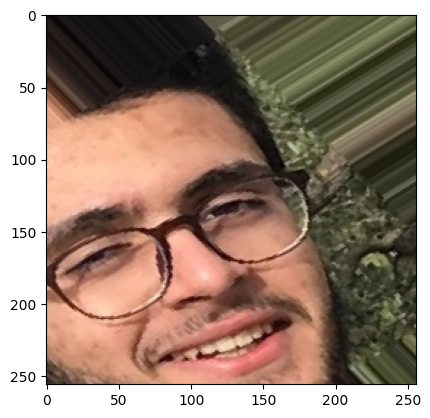

(18, 256, 256, 3) [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


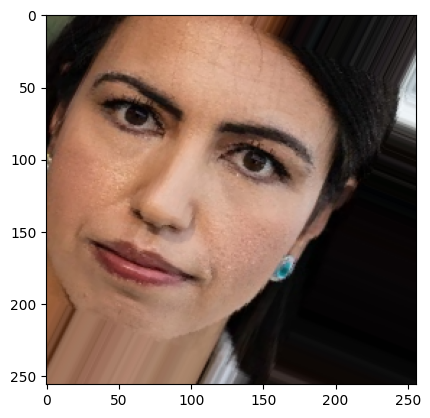

(18, 256, 256, 3) [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


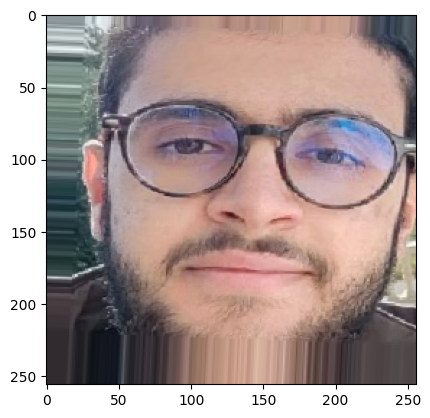

(18, 256, 256, 3) [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


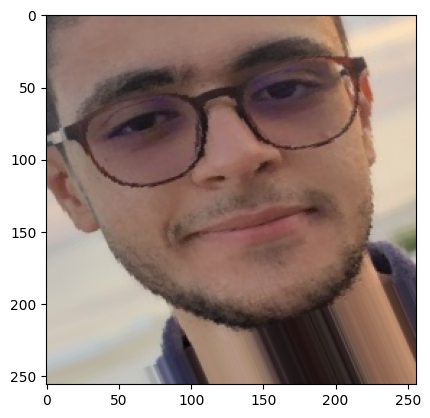

(18, 256, 256, 3) [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


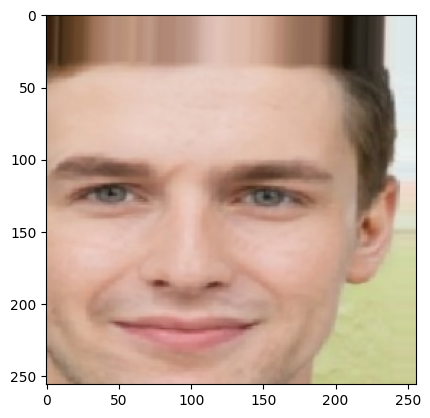

(18, 256, 256, 3) [[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


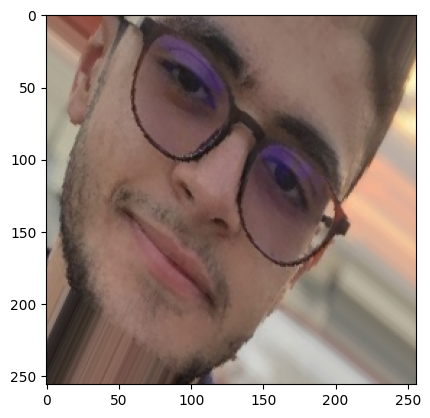

(18, 256, 256, 3) [[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


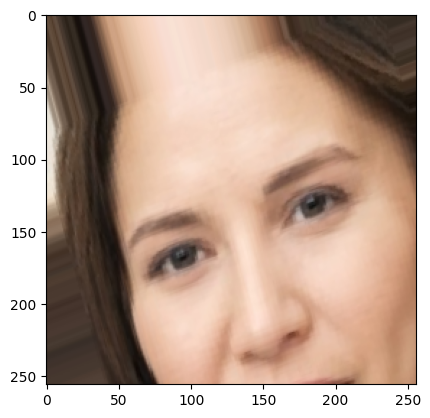

(18, 256, 256, 3) [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


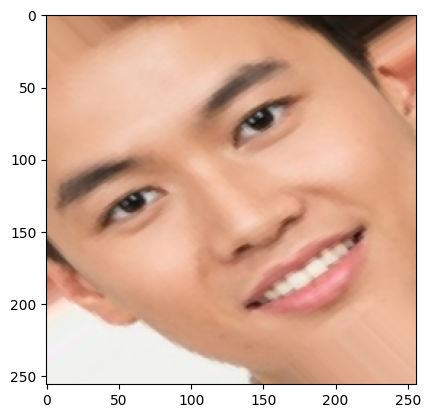

(18, 256, 256, 3) [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


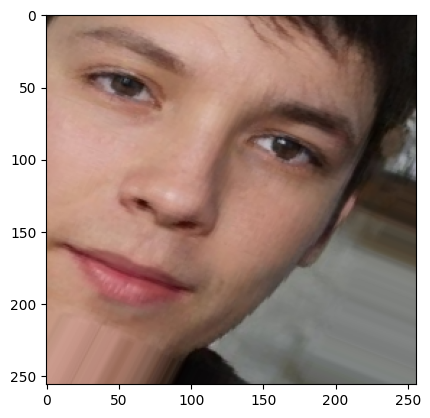

(18, 256, 256, 3) [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


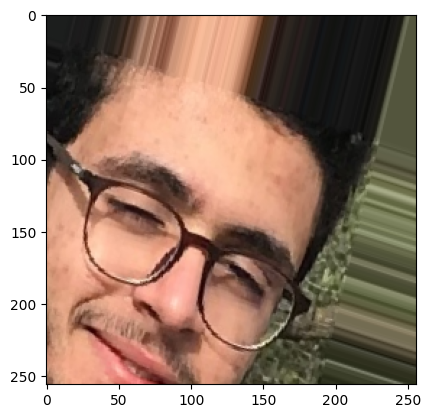

In [6]:
from keras.preprocessing.image import ImageDataGenerator
TrainingImagePath='./processed'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
dir_Iterator = datagen.flow_from_directory(
    TrainingImagePath,
    batch_size=32,
    save_format="jpg",
    target_size=(256, 256),
)
for i in range(10):
    img, label = dir_Iterator.next()
    print(img.shape, label)
    plt.imshow(img[0])
    plt.show()

training_set=dir_Iterator

## Load data and divide into train and test sets

In [8]:
TrainingImagePath='./processed';
# Loading dataset without augmentation
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)

testing_set = tf.keras.preprocessing.image_dataset_from_directory(
    TrainingImagePath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32,
)



Found 18 files belonging to 2 classes.
Using 15 files for training.
Found 18 files belonging to 2 classes.
Using 3 files for validation.


In [9]:
class_names = training_set.class_names
print(class_names)

['khalil', 'others']


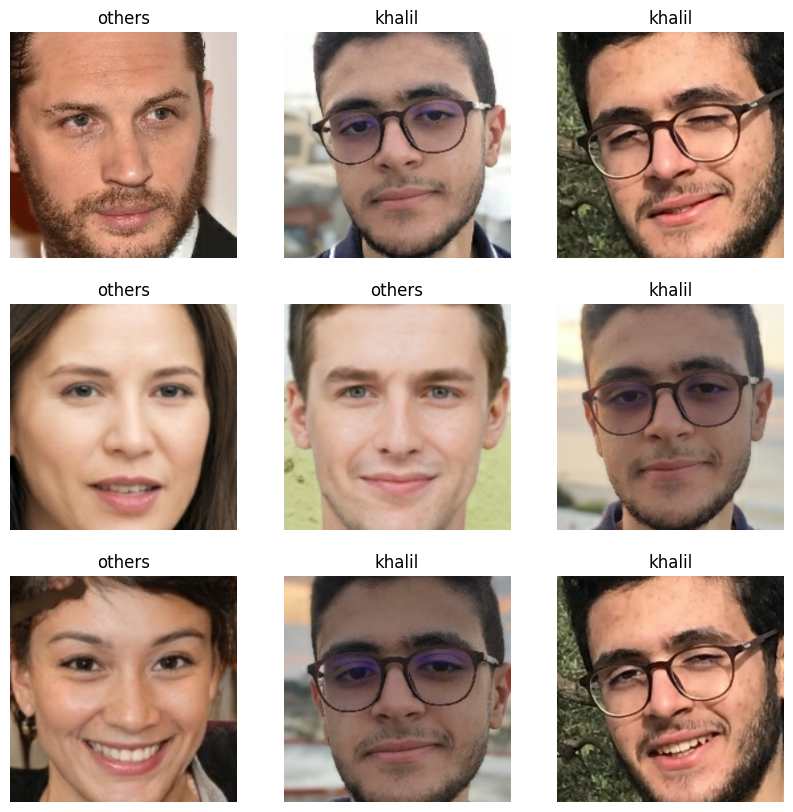

In [10]:
# Visualizing the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Standardize the data

In [11]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


A basic Keras model

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

Train the model (Train the model for 10 epochs with the Keras Model.fit method)



In [14]:
epochs=10
history = model.fit(
  training_set,
  validation_data=testing_set,
  epochs=epochs
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7057 - accuracy: 0.4667 - val_loss: 4.2180 - val_accuracy: 0.3333
Epoch 2/10
1/1 [==============================] - 1s 579ms/step - loss: 2.2975 - accuracy: 0.5333 - val_loss: 0.7826 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 1s 618ms/step - loss: 0.4754 - accuracy: 0.8667 - val_loss: 0.6685 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 1s 626ms/step - loss: 0.9419 - accuracy: 0.4667 - val_loss: 0.5937 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 1s 600ms/step - loss: 0.6921 - accuracy: 0.4667 - val_loss: 0.6313 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 703ms/step - loss: 0.5780 - accuracy: 1.0000 - val_loss: 0.7630 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 1s 602ms/step - loss: 0.5382 - accuracy: 0.6667 - val_loss: 0.7938 - val_accuracy: 0.3333
Epoch 8/10
1/1 [=======

Predict on new data


In [15]:
im_path='others15.jpg'

img = tf.keras.utils.load_img(
    im_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 126ms/step
This image most likely belongs to others with a 87.06 percent confidence.
